# Telegram chats and channels 

## Overlapping links and overlapping users in general and across three time periods (between 2017/03/18 - 2021/06/18)

In [1]:
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
import community # from python-louvain package
import pandas as pd
import numpy as np
from collections import Counter
import igraph as ig
import leidenalg as la
import random
import datetime as dt
random.seed(10)
import seaborn as sns
import pickle

In [2]:
#load data
d = pd.read_csv('/Users/monikasimon/PhD/Study_1/data/cleaned_data.csv', parse_dates = ['date'])
d.sort_values(by='date', ascending=True)

,date,url,source,type,user_data,ids,message_id,text_clean,links,link_frequency,text,text_lower,nolink_text,noemoji_text,spaced_text
2021618,2017-03-18 18:38:00+00:00,https://t.me/thierrybaudet,thierrybaudet,channel,"Channel(id=1102958542, title='Thierry Baudet',...",1.102959e+09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021617,2017-03-18 18:40:54+00:00,https://t.me/thierrybaudet,thierrybaudet,channel,"Channel(id=1102958542, title='Thierry Baudet',...",1.102959e+09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021616,2017-03-18 18:41:14+00:00,https://t.me/thierrybaudet,thierrybaudet,channel,"Channel(id=1102958542, title='Thierry Baudet',...",1.102959e+09,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021615,2017-03-18 18:41:49+00:00,https://t.me/thierrybaudet,thierrybaudet,channel,"Channel(id=1102958542, title='Thierry Baudet',...",1.102959e+09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021614,2017-03-18 18:43:08+00:00,https://t.me/thierrybaudet,thierrybaudet,channel,"Channel(id=1102958542, title='Thierry Baudet',...",1.102959e+09,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892663,2021-06-18 16:45:11+00:00,https://t.me/coronavaccinschatgroep,coronavaccinschatgroep,channel,"User(id=1187005152, is_self=False, contact=Fal...",1.187005e+09,8071.0,truth\n\nyellow_circle tmehopenotfear,NaN,NaN,Truth!\n\n🟡 t.me/HopeNotFear,truth!\n\n🟡 t.me/hopenotfear,truth!\n\n🟡 t.me/hopenotfear,truth!\n\n:yellow_circle: t.me/hopenotfear,truth!\n\n:yellow_circle : t.me/hopenotfear
1847599,2021-06-18 16:45:19+00:00,https://t.me/mondkapjesverzetgroep,mondkapjesverzetgroep,chat,"User(id=1067769489, is_self=False, contact=Fal...",1.067769e+09,52304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892662,2021-06-18 16:49:57+00:00,https://t.me/coronavaccinschatgroep,coronavaccinschatgroep,channel,"User(id=1757393767, is_self=False, contact=Fal...",1.757394e+09,8072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947647,NaT,Het word nu toch echt tijd om actie te gaan on...,Het word nu toch echt tijd om actie te gaan on...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#drop the last two rows due to errors
df = d.drop([d.index[1947647] , d.index[1947648]])
#len(df['source'].unique())
#save the clean file 
df.to_csv('/Users/monikasimon/PhD/Study_1/data/clean_df.csv')

In [75]:
#function to get the clean text colum of each time slice as a pickle file

def gettext(df):
    text = list(df['nolink_text'])
    cleaned_text = [x for x in text if str(x) != 'nan']
    return cleaned_text

#run function on the whole dataset
cleaned_text = gettext(df)

#save clean text as pickle
with open('/Users/monikasimon/PhD/Study_1/data/text.pkl', 'wb') as f:
    pickle.dump(cleaned_text, f)

In [5]:
#drop nans on date
df = df[df['date'].notna()]

In [6]:
#count number of unique users
unique_users = df['ids'].unique()
#number of unique users
len(unique_users)

55331

In [7]:
#count number of unique chats/channels
unique_groups = df['source'].unique()
len(unique_groups)
#number of unique links shared in messages
len(df['links'].unique())

217428

In [8]:
#reorganize dataset so that data is gruped by daily frequncy per chat/channel
df1 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'type'])['source'].agg(lambda x: "  ".join(x))) 
#df1


In [9]:
df1['unique_source'] = df1['source'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df1['unique_source'] = df1['unique_source'].str.strip(',') 

df1['unique_source'].iloc[79]

df1['unique_source_count'] = df1['unique_source'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df1['unique_source_count'].max()

66

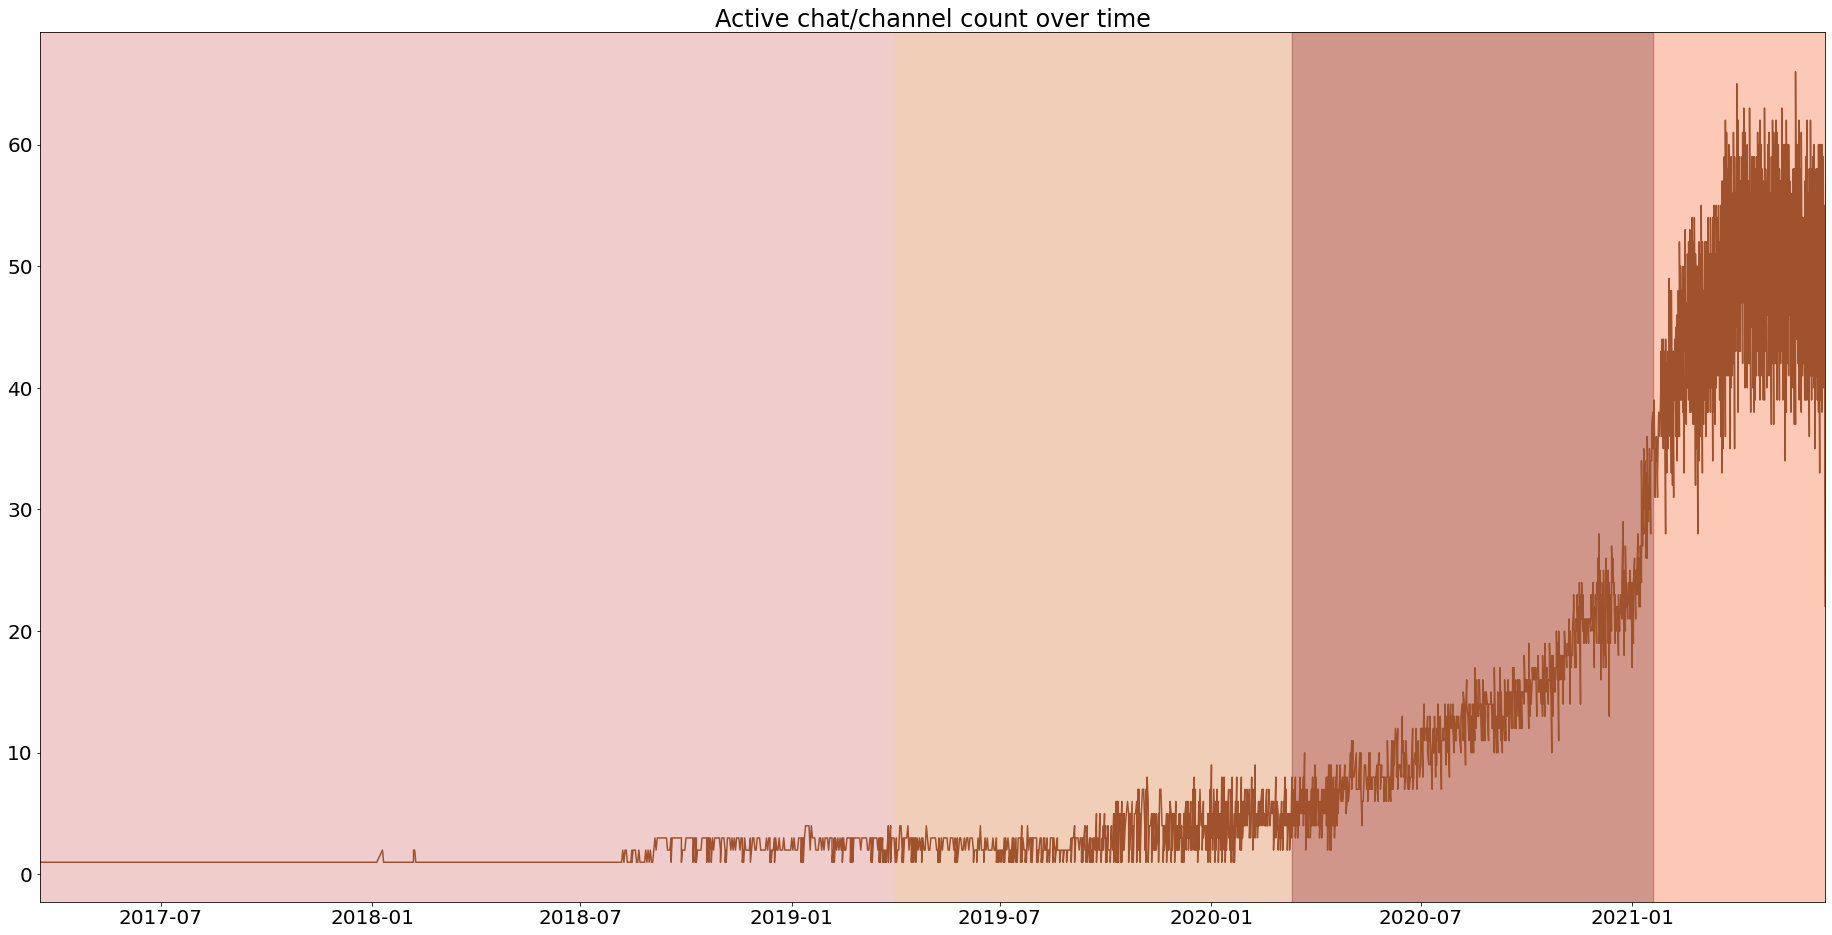

In [10]:
#plot active chats/channels over time
plt.rcParams.update({'font.size': 20})
node_plot = df1.reset_index()
plt.figure(figsize=(32,16))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
plt.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
plt.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
plt.plot(node_plot.date, node_plot.unique_source_count, color = 'sienna')
plt.title('Active chat/channel count over time')
plt.savefig('/Users/monikasimon/PhD/Study_1/Parool/chat_channel_count_overtime.png')
plt.show()

In [11]:
#change the type of ids from float to str
df['ids'] = df['ids'].astype(str)
df2 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'type'])['ids'].agg(lambda x: "  ".join(x))) 
df2['unique_ids'] = df2['ids'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df2['unique_ids'] = df2['unique_ids'].str.lstrip(',') 
df2['unique_ids'].iloc[79]

df2['unique_id_count'] = df2['unique_ids'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df2['unique_id_count'].max()

3675

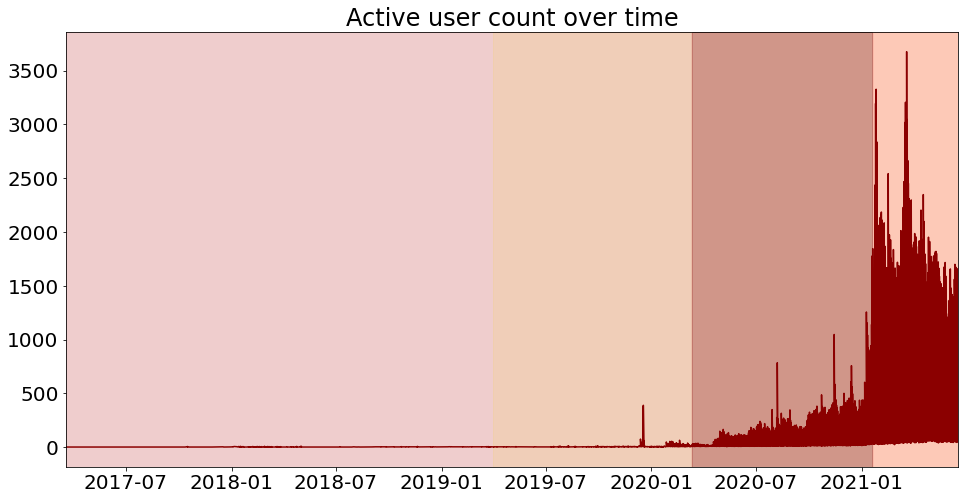

In [12]:
user_plot = df2.reset_index()
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
plt.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
plt.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
plt.plot(user_plot.date, user_plot.unique_id_count, color = 'darkred')
plt.title('Active user count over time')
plt.savefig('/Users/monikasimon/PhD/Study_1/NL-Telegram-nets/figures/user_count_overtime.png')
plt.show()

In [13]:
#change the type of links from float to str
df['links'] = df['links'].astype(str)

df3 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'type'])['links'].agg(lambda x: "  ".join(x))) 
df3['unique_links'] = df3['links'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df3['unique_links'] = df3['unique_links'].str.lstrip(',') 

df3['unique_links'].iloc[79]

df3['unique_link_count'] = df3['unique_links'].str.count(r" , ") #show number of unique sources- +1 added since if the source is unique no comma available
df3['unique_link_count'].max()

1104

In [14]:
df = df.reset_index()

In [15]:
df['month'] = df['date'].dt.month

In [16]:
df4 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'source'])['ids'].agg(lambda x: "  ".join(x))) #hourly sharing of urls per channel/chat
#df2['ids'].iloc[0]
df4['unique_ids'] = df4['ids'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df4['unique_ids'] = df4['unique_ids'].str.lstrip(',') 
df4['unique_ids'].iloc[79]
df4['unique_id_count'] = df4['unique_ids'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df4['unique_id_count'].max()

1056

In [17]:
df5 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'source'])['links'].agg(lambda x: "  ".join(x))) #hourly sharing of urls per channel/chat
#df5['ids'].iloc[0]
df5['unique_links'] = df5['links'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df5['unique_links'] = df5['unique_links'].str.lstrip(',') 
df5['unique_links'].iloc[79]
df5['unique_link_count'] = df5['unique_links'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df5['unique_link_count'].max()

532

In [20]:
df6 = df4.reset_index().set_index('date')['2019-12-15': '2019-12-31'] #find the reason why there's a spike in activity in Dec. 2019
df6.sort_values(by='unique_id_count', ascending=False)

,source,ids,unique_ids,unique_id_count
date,,,,
2019-12-18 00:00:00+00:00,beeldmateriaal,873281665.0 873281665.0 916665836.0 8732816...,"1060964035.0 , 902345613.0 , 915985181.0 , 101...",388
2019-12-17 00:00:00+00:00,beeldmateriaal,989714888.0 954118703.0 944918635.0 6553510...,"947630863.0 , 902345613.0 , 1037323020.0 , 621...",368
2019-12-19 00:00:00+00:00,beeldmateriaal,626163708.0 1054367675.0 1054367675.0 10514...,"711096950.0 , 927444223.0 , 902345613.0 , 2156...",60
2019-12-16 00:00:00+00:00,beeldmateriaal,939625428.0 566709353.0 939625428.0 9396254...,"711096950.0 , 1052314487.0 , 1044652951.0 , 90...",43
2019-12-24 00:00:00+00:00,FvDgroup,915372338.0 14726745.0 14726745.0 14726745....,"14726745.0 , 991398466.0 , 646826166.0 , 20291...",5
...,...,...,...,...
2019-12-20 00:00:00+00:00,FvDgroup,1069017886.0,1069017886.0,1
2019-12-19 00:00:00+00:00,thepostonline,1204290075.0 1204290075.0 1204290075.0 1204...,1204290075.0,1
2019-12-19 00:00:00+00:00,natuurlijf_chat,897327035.0,897327035.0,1


In [21]:
df7 = df4.reset_index().set_index('date')['2020-08-30': '2021-01-19']
df7.sort_values(by = 'unique_id_count', ascending = False)

,source,ids,unique_ids,unique_id_count
date,,,,
2020-11-14 00:00:00+00:00,nederlandsverzet21,1489238293.0 15697090.0 1364982615.0 123190...,"1294209493.0 , 632673648.0 , 1304088200.0 , 95...",747
2021-01-09 00:00:00+00:00,nederlandsverzet21,1055264928.0 1492700326.0 1459306167.0 7090...,"1435695214.0 , 1068794489.0 , 1445181017.0 , 1...",604
2021-01-10 00:00:00+00:00,nederlandsverzet21,676142259.0 1330776023.0 1433682747.0 14002...,"1281772934.0 , 1554864939.0 , 1005398340.0 , 2...",455
2021-01-19 00:00:00+00:00,nederlandsverzet21,1552508402.0 1313202040.0 587232073.0 58723...,"1402759778.0 , 873367260.0 , 1509261929.0 , 15...",450
2021-01-19 00:00:00+00:00,klokkenchat,919284579.0 1107051772.0 nan 1107051772.0 ...,"1555850476.0 , 1430491095.0 , 1001561151.0 , 1...",433
...,...,...,...,...
2020-11-15 00:00:00+00:00,klokkenluiders,1306353747.0 1306353747.0 1306353747.0 1306...,1306353747.0,1
2020-11-15 00:00:00+00:00,langefranspodcast,1467672805.0 1467672805.0,1467672805.0,1
2020-11-15 00:00:00+00:00,leefbewust,1312698622.0 1312698622.0,1312698622.0,1


In [22]:
df8 = df4.reset_index().set_index('date')['2021-01-10': '2021-06-18']
df8.sort_values(by = 'unique_id_count', ascending = False).head(30)

,source,ids,unique_ids,unique_id_count
date,,,,
2021-01-25 00:00:00+00:00,klokkenchat,1146645410.0 1225087615.0 1419152507.0 1320...,"931208423.0 , 1555850476.0 , 1505406114.0 , 13...",1056
2021-01-26 00:00:00+00:00,klokkenchat,1163603103.0 1519400007.0 1306353747.0 1256...,"931208423.0 , 1555850476.0 , 1402759778.0 , 14...",973
2021-03-20 00:00:00+00:00,klokkenchat,1679915998.0 1546952568.0 44836539.0 155904...,"931208423.0 , 1329745828.0 , 1679915998.0 , 13...",943
2021-01-24 00:00:00+00:00,klokkenchat,1119864650.0 1541663551.0 1486823233.0 1541...,"1555850476.0 , 931208423.0 , 1355537194.0 , 81...",922
2021-03-17 00:00:00+00:00,klokkenchat,1582135400.0 nan 1448785731.0 1590165932.0 ...,"931208423.0 , 1329745828.0 , 1355537194.0 , 15...",891
2021-01-27 00:00:00+00:00,DeBataafseRepubliek,956182962.0 1519609358.0 1207933757.0 95618...,"1435695214.0 , 1409662892.0 , 1001561151.0 , 1...",879
2021-03-20 00:00:00+00:00,vervoervoordemonstranten,1466328195.0 9005882.0 1256561456.0 2351755...,"1329745828.0 , 1494759464.0 , 1437031637.0 , 1...",857
2021-03-18 00:00:00+00:00,klokkenchat,1657680868.0 1559047209.0 1258649037.0 1690...,"931208423.0 , 1518120863.0 , 871838935.0 , 100...",849
2021-03-28 00:00:00+00:00,klokkenchat,1205653032.0 935896629.0 1657680868.0 16576...,"931208423.0 , 1555884413.0 , 871838935.0 , 137...",816


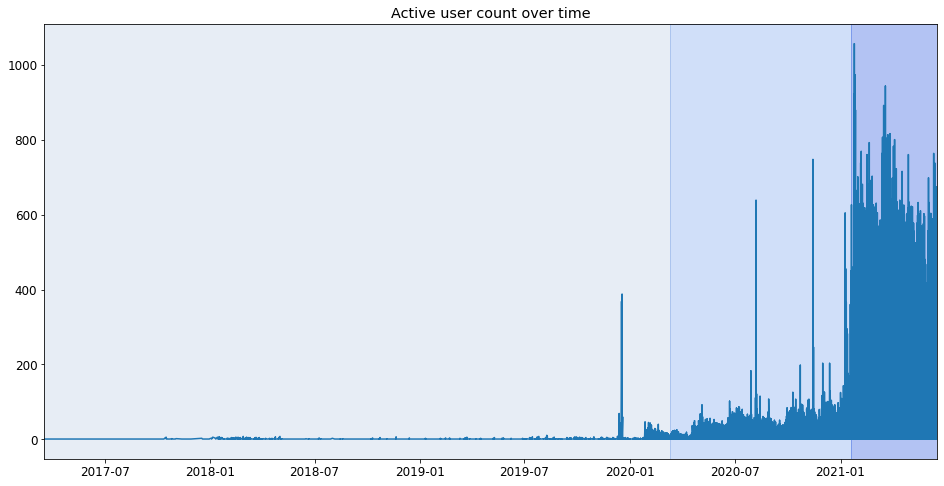

In [23]:
user_count_plot = df4.reset_index()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='lightsteelblue', alpha=0.3)
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='cornflowerblue', alpha=0.3)
plt.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='royalblue', alpha=0.4)
plt.plot(user_count_plot.date, user_count_plot.unique_id_count)
plt.title('Active user count over time')
plt.show()

In [24]:
df4.sort_values(by=['date','unique_id_count'],ascending=[False,False],inplace=True)
df4.reset_index().loc[df4.reset_index()['date'] == 2019-12-21, 'unique_ids']

Series([], Name: unique_ids, dtype: object)

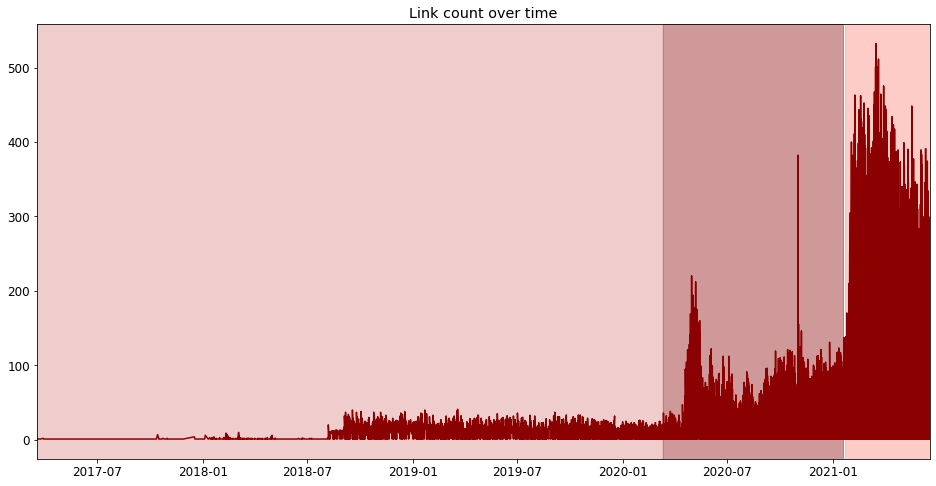

In [25]:
link_count_plot = df5.reset_index()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3)
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4)
plt.axvspan(dt.date(2021,1,21), dt.date(2021,6,18), color='salmon', alpha=0.4)
plt.plot(link_count_plot.date, link_count_plot.unique_link_count, color = 'darkred')
plt.title('Link count over time')
plt.show()

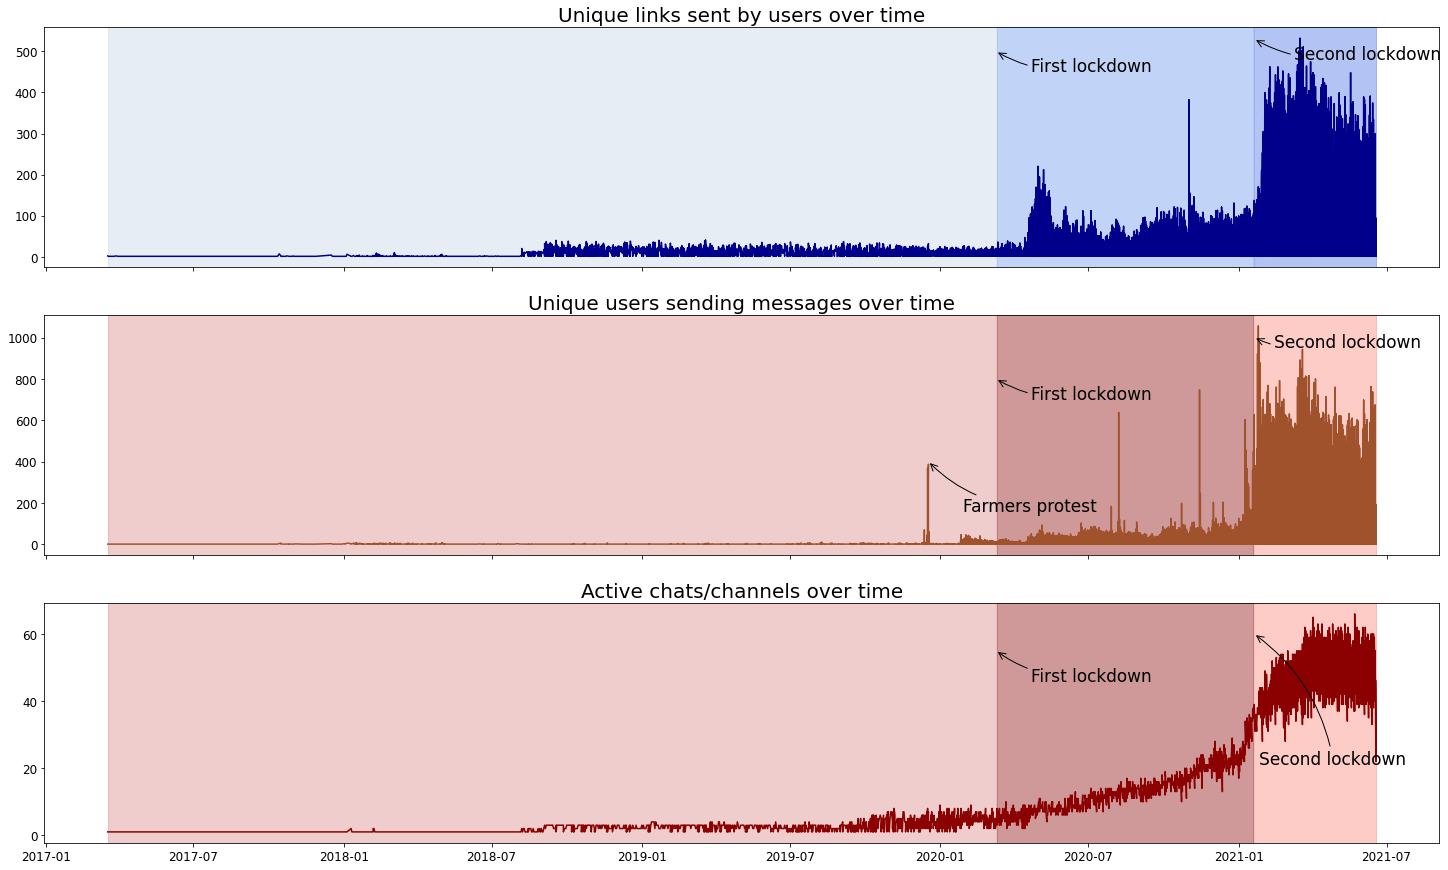

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True, figsize = (25,15))
plt.rcParams.update({'font.size': 17})
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
ax1.plot(link_count_plot.date, link_count_plot.unique_link_count, color = 'darkblue')
ax1.set_title('Unique links sent by users over time',fontsize = 20)
ax1.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='lightsteelblue', alpha=0.3, linestyle = '-')
#ax1.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
ax1.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='cornflowerblue', alpha=0.4, linestyle = '-')
ax1.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='royalblue', alpha=0.4,linestyle = '-' )
ax2.plot(user_count_plot.date, user_count_plot.unique_id_count, color = 'sienna')
ax2.set_title('Unique users sending messages over time', fontsize = 20)
ax2.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
#ax2.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
ax2.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
ax2.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
ax3.plot(node_plot.date, node_plot.unique_source_count, color = 'darkred')
ax3.set_title('Active chats/channels over time',fontsize = 20 )
ax3.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
#ax3.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
ax3.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
ax3.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
# Adding annotation on the plots.
ax1.annotate("First lockdown", xy=(dt.date(2020,3,10), 500),  xycoords='data',
            xytext=(35, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
ax1.annotate("Second lockdown", xy=(dt.date(2021,1,20), 530),  xycoords='data',
            xytext=(40, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2")) 
ax2.annotate("Farmers protest", xy=(dt.date(2019,12,18), 400),  xycoords='data',
            xytext=(35, -50), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))                            
ax2.annotate("First lockdown", xy=(dt.date(2020,3,10), 800),  xycoords='data',
            xytext=(35, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
ax2.annotate("Second lockdown", xy=(dt.date(2021,1,20), 1000),  xycoords='data',
            xytext=(20, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                      connectionstyle="arc3,rad=-0.2"))      
ax3.annotate("First lockdown", xy=(dt.date(2020,3,10), 55),  xycoords='data',
            xytext=(35, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
ax3.annotate("Second lockdown", xy=(dt.date(2021,1,20), 60),  xycoords='data',
            xytext=(5, -130), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2"))
plt.savefig('/Users/monikasimon/PhD/Study_1/NL-Telegram-nets/figures/Users_links_sources_overtime.png')

### Slice data into three time slices

T1 = from the first data point (2017/03/18) till a day before the WHO declared COVID-19 as a pandemic (2020/03/10) T2 = From the date WHO declares COVID-19 as a pandemic (2020/03/11) till a day before the Dutch government introduces the hard lockdown that included a curfew (2021/01/19) T3 = From the day of the curfew (2021/01/20) till the last datapoint in dataset (2021/06/18)

In [41]:
df = df.set_index('date')

In [42]:
df_T1 =df.sort_index().loc['2017-03-18':'2020-03-10'] #covid is a pandemic according to the who 11/3/2020
len()df_T1 #55,309 rows
#df_T1.to_csv('/Users/monikasimon/PhD/Study_1/data/T1_data.csv')

In [49]:
df_T2 = df.sort_index()['2020-03-11': '2021-01-19'] #T2 = before the introduction of the curfew measure
len(df_T2) #486,181 rows
#df_T2.to_csv('/Users/monikasimon/PhD/Study_1/data/T2_data.csv')

486181

In [50]:
df_T3 = df.sort_index()['2021-01-20': '2021-06-18'] #T3 = after the introduction of the curfew measure until last datapoint
len(df_T3) #1,492,171 rows 
#df_T3.to_csv('/Users/monikasimon/PhD/Study_1/data/T3_data.csv')

In [69]:
#save clean text as pickle for each time slice
text_1 = gettext(df_T1)
text_2  = gettext(df_T2)
text_3 = gettext(df_T3)

with open('/Users/monikasimon/PhD/Study_1/data/text_T1.pkl', 'wb') as f:
    pickle.dump(text_1, f)

with open('/Users/monikasimon/PhD/Study_1/data/text_T2.pkl', 'wb') as f:
    pickle.dump(text_2, f)
    
with open('/Users/monikasimon/PhD/Study_1/data/text_T3.pkl', 'wb') as f:
    pickle.dump(text_3, f)

In [76]:
len(text_1)

38693

In [77]:
len(text_2)

354360

In [78]:
len(text_3)

1059864